In [2]:
import cv2
import pathlib
import numpy as np
from PIL import Image
from sys import exit
from io import BytesIO
from numpy import array
from scipy.cluster.vq import kmeans
from matplotlib import pyplot as plt
from colorsys import rgb_to_hsv, hsv_to_rgb
from IPython.display import display, HTML

In [3]:
gif_df = pathlib.Path("./img/gif")

In [4]:
gif_list = list(gif_df.glob("*.gif"))

In [5]:
gif_list[:5]

[PosixPath('img/gif/03274_1925-0001.gif'),
 PosixPath('img/gif/05791_04_1951-0000.gif'),
 PosixPath('img/gif/05844_1936-0001.gif'),
 PosixPath('img/gif/04369_1908-0001.gif'),
 PosixPath('img/gif/03952_1918-0001.gif')]

In [6]:
DEFAULT_NUM_COLORS = 6

In [7]:
DEFAULT_MINV = 0
DEFAULT_MAXV = 256

In [8]:
DEFAULT_BOLD_ADD = 50

In [9]:
THUMB_SIZE = (200, 200)
SCALE = 256.0

In [10]:
def down_scale(x):
    return x / SCALE

In [11]:
def up_scale(x):
    return int(x * SCALE)

In [12]:
def clamp(color, min_v, max_v):
    """
    Clamps a color such that the value (lightness) is between min_v and max_v.
    """
    # use down_scale to convert color to value between 0-1 as expected by rgb_hsv
    h, s, v = rgb_to_hsv(*map(down_scale, color))
    # also convert the min_v and max_v to values between 0-1
    min_v, max_v = map(down_scale, (min_v, max_v))
    # get the maximum of the min value and the color's value (therefore bumping it up if needed)
    # then get the minimum of that number and the max_v (bumping the value down if needed)
    v = min(max(min_v, v), max_v)
    # convert the h, s, v(which has been clamped) to rgb, apply upscale to get it back to 0-255, return tuple R,G,B
    return tuple(map(up_scale, hsv_to_rgb(h, s, v)))

In [13]:
def order_by_hue(colors):
    """
    Orders colors by hue.
    """
    hsvs = [rgb_to_hsv(*map(down_scale, color)) for color in colors]
    hsvs.sort(key=lambda t: t[0])
    return [tuple(map(up_scale, hsv_to_rgb(*hsv))) for hsv in hsvs]

In [14]:
def get_colors(img):
    """
    Returns a list of all the image's colors.
    """
    w, h = img.size
    # convert('RGB') converts the image's pixels info to RGB 
    # getcolors() returns an unsorted list of (count, pixel) values
    # w * h ensures that maxcolors parameter is set so that each pixel could be unique
    # there are three values returned in a list
    return [color for count, color in img.convert('RGB').getcolors(w * h)]

In [15]:
def hexify(rgb):
    return "#{0:02x}{1:02x}{2:02x}".format(*rgb)

In [16]:
def brighten(color, brightness):
    """
    Adds or subtracts value to a color.
    """
    h, s, v = rgb_to_hsv(*map(down_scale, color))
    return tuple(map(up_scale, hsv_to_rgb(h, s, v + down_scale(brightness))))

In [17]:
def colorz(image_obj, n=DEFAULT_NUM_COLORS, min_v=DEFAULT_MINV, max_v=DEFAULT_MAXV,
           bold_add=DEFAULT_BOLD_ADD, order_colors=True):
    """
    Get the n most dominant colors of an image.
    Clamps value to between min_v and max_v.

    Total number of colors returned is n, optionally ordered by hue.
    Returns as a list of RGB triples.

    """
    img = Image.open(image_obj)
    img.thumbnail(THUMB_SIZE) # replace with a thumbnail with same aspect ratio, no larger than THUMB_SIZE
    obs = get_colors(img) # gets a list of RGB colors (e.g. (213, 191, 152)) for each pixel
    # adjust the value of each color, if you've chosen to change minimum and maximum values
    clamped = [clamp(color, min_v, max_v) for color in obs] 
    # turns the list of colors into a numpy array of floats, then applies scipy's k-means function
    clusters, _ = kmeans(array(clamped).astype(float), n) 
    colors = order_by_hue(clusters) if order_colors else clusters
    return list(map(hexify, colors))

In [18]:
def analyze(img_path):
    html = ""
    color_list = colorz(img_path)
    for i, color in enumerate(color_list):
        html += f'<rect x="{i * 30}" y="0" width="30" height="30" fill="{color}" />'
    return f'<img src="{img_path}"><svg height="30" width="210">{html}</svg>'

In [46]:
# Automatic brightness and contrast optimization with optional histogram clipping
def automatic_brightness_and_contrast(img_path, clip_hist_percent=1):
    cap = cv2.VideoCapture(str(img_path))
    ret, image = cap.read()
    cap.release()    
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Calculate grayscale histogram
    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    hist_size = len(hist)
    
    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index -1] + float(hist[index]))
    
    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum/100.0)
    clip_hist_percent /= 2.0
    
    # Locate left cut
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1
    
    # Locate right cut
    maximum_gray = hist_size -1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1
    
    # Calculate alpha and beta values
    alpha = 255 / (maximum_gray - minimum_gray)
    beta = -minimum_gray * alpha

    auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return (auto_result, alpha, beta)

In [48]:
auto_result, alpha, beta = automatic_brightness_and_contrast(gif_list[1])

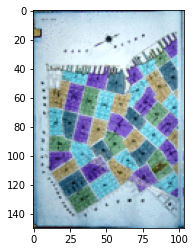

In [50]:
plt.imshow(auto_result)
plt.show()

In [ ]:
for gif in gif_list[:2]:
    html = analyze(gif)
    display(HTML(html))